## End of distribution Imputation ==> Feature Engine


### What is Feature Engine

Feature Engine is an open source python package that I created at the back of this course. 

- Feature Engine includes all the feature engineering techniques described in the course
- Feature Engine works like to Scikit-learn, so it is easy to learn
- Feature Engine allows you to implement specific engineering steps to specific feature subsets
- Feature Engine can be integrated with the Scikit-learn pipeline allowing for smooth model building
- 
**Feature Engine allows you to design and store a feature engineering pipeline with bespoke procedures for different variable groups.**

-------------------------------------------------------------------
Feature Engine can be installed via pip ==> pip install feature-engine

- Make sure you have installed feature-engine before running this notebook

For more information visit:
my website

## In this demo

We will use Feature Engine to perform End of distribution imputation using the Ames House Price Dataset.

- To download the dataset visit the lecture **Datasets** in **Section 1** of the course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature engine
from feature_engine import missing_data_imputers as mdi

In [2]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

LotFrontage  MasVnrArea BsmtQual FireplaceQu  GarageYrBlt  SalePrice
0         65.0       196.0       Gd         NaN       2003.0     208500
1         80.0         0.0       Gd          TA       1976.0     181500
2         68.0       162.0       Gd          TA       2001.0     223500
3         60.0         0.0       TA          Gd       1998.0     140000
4         84.0       350.0       Gd          TA       2000.0     250000

In [3]:
data.isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
BsmtQual       0.025342
FireplaceQu    0.472603
GarageYrBlt    0.055479
SalePrice      0.000000
dtype: float64

All the predictor variables contain missing data.

In [4]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 5), (438, 5))

### Feature Engine captures the numerical variables automatically

In [5]:
# we call the imputer from feature engine

# we specify whether we want to find the values using
# the gaussian approximation or the inter-quantal range
# proximity rule.

# in addition we need to specify if we want the values placed at 
# the left or right tail

imputer = mdi.EndTailImputer(distribution='gaussian', tail='right')

In [6]:
# we fit the imputer

imputer.fit(X_train)

EndTailImputer(distribution='gaussian', fold=3, tail='right',
        variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])

In [7]:
# we see that the imputer found the numerical variables to
# impute with the end of distribution value

imputer.variables

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [8]:
# here we can see the values that will be used
# to replace NA for each variable

imputer.imputer_dict_

{'LotFrontage': 138.9022201686726,
 'MasVnrArea': 648.3947111415157,
 'GarageYrBlt': 2052.9707419772235}

In [9]:
# and this is how those values were calculated
# which is how we learnt in the first notebooks of
# this section

X_train[imputer.variables].mean() + 3 * X_train[imputer.variables].std()

LotFrontage     138.902220
MasVnrArea      648.394711
GarageYrBlt    2052.970742
dtype: float64

In [10]:
# feature engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

BsmtQual FireplaceQu  LotFrontage  MasVnrArea  GarageYrBlt
64         Gd         NaN    138.90222       573.0  1998.000000
682        Gd          Gd    138.90222         0.0  1996.000000
960        TA         NaN     50.00000         0.0  2052.970742
1384       TA         NaN     60.00000         0.0  1939.000000
1100       TA         NaN     60.00000         0.0  1930.000000

In [11]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
dtype: float64

## Feature engine allows you to specify variable groups easily

In [12]:
# let's do it imputation but this time
# and let's do it over 2 of the 3 numerival variables

# let's also select the proximity rule on the left tail

imputer = mdi.EndTailImputer(distribution='skewed', tail='left',
                             variables=['LotFrontage', 'MasVnrArea'])

imputer.fit(X_train)

EndTailImputer(distribution='skewed', fold=3, tail='left',
        variables=['LotFrontage', 'MasVnrArea'])

In [13]:
# now the imputer uses only the variables we indicated

imputer.variables

['LotFrontage', 'MasVnrArea']

In [14]:
# and we can see the value assigned to each variable
imputer.imputer_dict_

{'LotFrontage': -8.0, 'MasVnrArea': -510.0}

In [15]:
# feature engine returns a dataframe

tmp = imputer.transform(X_train)

# let's check null values are gone
tmp[imputer.variables].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

## Feature engine can be used with the Scikit-learn pipeline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000A9D76792E8>,
      dtype=object)

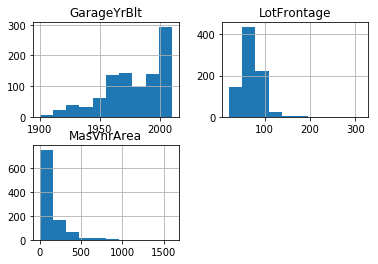

In [16]:
# let's look at the distributions to determine the
# end tail value selection method

X_train.hist()

All variables are skewed. For this demo, I will use the proximity rule for GarageYrBlt and MasVnrArea, and the Gaussian approximation for LotFrontage.

In [17]:
pipe = Pipeline([
    ('imputer_skewed', mdi.EndTailImputer(distribution='skewed', tail='right',
                                          variables=['GarageYrBlt', 'MasVnrArea'])),

    ('imputer_gaussian', mdi.EndTailImputer(distribution='gaussian', tail='right',
                                            variables=['LotFrontage'])),
])

In [18]:
pipe.fit(X_train)

Pipeline(memory=None,
     steps=[('imputer_skewed', EndTailImputer(distribution='skewed', fold=3, tail='right',
        variables=['GarageYrBlt', 'MasVnrArea'])), ('imputer_gaussian', EndTailImputer(distribution='gaussian', fold=3, tail='right',
        variables=['LotFrontage']))])

In [19]:
pipe.named_steps['imputer_skewed'].imputer_dict_

{'GarageYrBlt': 2121.0, 'MasVnrArea': 680.0}

In [20]:
pipe.named_steps['imputer_gaussian'].imputer_dict_

{'LotFrontage': 138.9022201686726}

In [21]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

BsmtQual       0.023483
FireplaceQu    0.467710
LotFrontage    0.000000
MasVnrArea     0.000000
GarageYrBlt    0.000000
dtype: float64

There are no more null values for the 3 imputed numerical variables.